In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
path = Path('/app/data/raw/2022.03.22OGW.xlsx')
assert path.exists()

In [5]:
# eip = dbcp.extract.eip_infrastructure.extract(path)
# hardcode the extract function so this notebook can be easily rerun in the future without maintenance
proj = pd.read_excel(path, sheet_name='Project')

In [6]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [7]:
proj.shape

(672, 47)

# Cleaning
## Projects Cleaning
- [x] Accuracy
- [x] Atomicity
- [ ] Consistency
- [x] Completeness
- [x] Uniformity
- [x] Validity
    - [x] Range Validation
    - [x] Uniqueness Validation
    - [x] Set Membership Validation
    - [x] Type Validation
    - [x] Cross-Field Validation

### Accuracy
The biggest accuracy risks for this dataset are probably 1) bad reporting to the EPA (would take a huge research effort to double check that) and 2) transcription errors by EIP between the PDFs and the database. I'll do a little spot check to guard againt the second.

Results: I only checked 3 facilities but still managed to find conflicting information about CO2e numbers 😕

In [11]:
proj.sample(3, random_state=42)

,id,name,created_by,created_on,modified_by,modified_on,private,Facility (ID),Facility,Project Description,Classification,Industry Sector,Project Type,"Product Type (Private, AS)",Air Construction (ID),Air Construction,Air Operating (ID),Air Operating,NGA (ID),NGA,MARAD (ID),MARAD,Other Permits (ID),Other Permits,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Sulfur Dioxide (SO2),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs),Total Wetlands Affected Temporarily (acres),Total Wetlands Affected Permanently (acres),Detailed Permitting History,Emission Accounting Notes,Construction Status Last Updated,Operating Status,Actual or Expected Completion Year,Operating Status Sources and Notes,Operating Status Source Document(s),Operating Status Notes,Project Cost (million $),Number of Jobs Promised,Research Notes,Bloomberg Target List,Bloomberg Secondary Target List,Bloomberg Flag
361,3091,Sinton Compressor Station - Initial Construction,EIP Test Account,2021-05-24T22:56:59.087382,Alexandra Shaykevich,2022-01-18T20:34:12.439103,False,1070,Sinton Compressor Station[1070],Construction of a new compressor station as pa...,New,Natural Gas,Compressor Station,NaN,1755,136544[1755],NaN,NaN,"3476, 3610, 4625","CP18-512 and CP18-513[3476], CP12-507 and CP12...",NaN,NaN,NaN,NaN,450475.0,21.12,175.24,26.73,43.71,179.10,7.8000,NaN,NaN,TCEQ Permit no. 136544 (issued 1/5/2016; revis...,Criteria emissions updated w/ values in most r...,NaN,Operating,2018,In-service notification for the CC LNG Pipelin...,{u'url': u'https://api.oilandgaswatch.org/d/ab...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,2884,Golden Pass LNG Export Terminal - Initial Cons...,EIP Test Account,2021-05-24T22:56:59.087382,Kira Burkhart,2022-02-24T19:27:42.761184,False,883,Golden Pass LNG Export Terminal[883],Construction of a 15.6 million tpy natural gas...,Expansion,Liquefied Natural Gas,Liquefied Natural Gas Terminal or Liquefaction...,NaN,1974,"116055, PSDTX1386, and GHGPSDTX100[1974]",NaN,NaN,"3439, 4569, 3556","CP14-517 and CP14-518[3439], CP20-459[4569], C...",NaN,NaN,NaN,NaN,4940072.0,118.91,670.89,256.51,9.42,843.93,NaN,388.0,376.0,"GHGPSDTX100 (issued 9/11/2015), 116055 and PSD...","App to modify permit 116055 to utilize ""altern...",2022-02-24,Under construction,2024/2026,GPLNG commenced construction of the export fac...,NaN,NaN,NaN,NaN,FEED contract awarded to Chiyoda Corp; EPC awa...,NaN,NaN,NaN
481,3925,NGPL Gulf Coast Southbound Project - NGPL Comp...,EIP Support,2021-09-03T18:26:42.450697,Louisa Markow,2021-12-02T20:56:24.254837,False,3826,NGPL Compressor Station 394[3826],Expansion of an existing compressor station as...,Expansion,Natural Gas,Compressor Station,NaN,NaN,NaN,NaN,NaN,3512,CP19-99[3512],NaN,NaN,NaN,NaN,173.4,0.00,0.00,0.07,0,0.00,0.0063,NaN,NaN,NaN,NaN,NaN,Operating,2023,NaN,NaN,NaN,NaN,NaN,pg 49 (Table 12) https://elibrary.ferc.gov/idm...,NaN,NaN,NaN


Sinton Compresson Station: [permit](https://api.oilandgaswatch.org/d/98/f8/98f85e1d868f4e63966d01637fc5408c.1638199494.pdf) confirmed all emissions numbers EXCEPT GHG (not mentioned). I couldn't find a source for that 450,475 number. The [environmental impact statement](https://www.ferc.gov/sites/default/files/2020-05/corpuschristiFEIS.pdf) submitted to FERC claims only 155,000 tpy of CO2e.

Golden Pass LNG Terminal: GHG numbers confirmed on page 25 of [the permit doc](https://api.oilandgaswatch.org/d/18/54/18545bea701e4bed938050997b308fdf.1638219234.pdf)

NGPL Compressor Station: had to go digging for the docs, but found the [FERC Environmental Assessment](https://www.ferc.gov/sites/default/files/2020-04/CP19-99-EA.pdf) that confirms the 173.4 tpy CO2e numbers.

### Atomicity
By inspection I see that all the ID and associated name fields can contain multiple values. I'll only worry about Facility IDs and Air Construction Permit IDs.

On a related note, both the facilities table and the project table have a column linking the two. I'll have to combine them to get a complete association entity table.

### Completeness
For this purpose, I'll limit the scope of 'completeness' to only look at missing values within the data. For better or worse, it is EIP's job to ensure projects are in the dataset at all.

We are not interested in already-operating projects, so I'll remove those and assess completeness based on the remaining subset.

Notable missing values and lack of missing values:
* all projects are linked to a facility ID!
* all projects have an operating status
* 95/308 (30.8%) are missing Air Construction Permit IDs. Likely because many of these projects are too new to have gone through the permitting process.
* 86/308 (27.9%) are missing CO2e estimates. Same newness reason.

For evidence of the "too new to have a permit" hypothesis, compare completeness of criteria pollutants before/after subsetting by operational status:
* For all projects, only around 66/672 (9.8%) are missing criteria pollutants (NOx, VOC, CO, SO2, PM2.5)
* For not-operational projects, 60/308 (19.5%) are missing criteria pollutants. So nearly all of the missing values.

In [24]:
def calc(num, denom=308):
    percent = 1- num/denom
    n = denom - num
    return f"{n}/{denom} ({percent*100:.1f}%)"

In [27]:
calc(248)

'60/308 (19.5%)'

In [12]:
len(proj)

672

In [22]:
proj['Operating Status'].value_counts()

Operating              364
Pre-construction       170
Announced               40
Under construction      35
Canceled                30
Partially operating     16
On hold                 15
Unknown                  1
Commissioning            1
Name: Operating Status, dtype: int64

In [23]:
proj.loc[proj['Operating Status'].ne('Operating'),:].count().T

id                                             308
name                                           308
created_by                                     308
created_on                                     308
modified_by                                    308
modified_on                                    308
private                                        308
Facility (ID)                                  308
Facility                                       308
Project Description                            303
Classification                                 307
Industry Sector                                308
Project Type                                   308
Product Type (Private, AS)                      61
Air Construction (ID)                          213
Air Construction                               213
Air Operating (ID)                               6
Air Operating                                    6
NGA (ID)                                       115
NGA                            

### Consistency - defer
Defer until I've cleaned the related datasets
### Uniformity
Important columns to check consistent representation:
* ID fields (check consistent array delimiters)
* all the emissions - check metric vs short tons

Secondary importance:
* modified_on
* project cost (supposed to be in millions $)
* jobs promised has inconsistent formatting/delimiters

#### ID Fields
Want to check for consistent array delimiters.

In [28]:
# exclude ID cols with numeric types (no arrays present)
id_cols = [col for col in proj.columns if '(ID)' in col and pd.api.types.is_object_dtype(proj[col])]
id_cols

['Facility (ID)', 'Air Construction (ID)', 'Air Operating (ID)', 'NGA (ID)']

In [29]:
# mandatory opening pattern, optional delimiter, optional repeating pattern, optional closing pattern, mandatory end of line
array_pattern = r'(?:\d{3,5})(?:, ?)?(?:\d{3,5}, ?)*(?:\d{3,5})?$'

In [30]:
test_case = pd.Series([
    '1234',
    '1234,567',
    '1234, 567',
    '12345, 678, 9012',
    '1234\t5678', # tab is bad, no comma
    '12, 3456', # too short
    '1234    5678', # too many spaces, no comma
])
pd.concat([test_case, test_case.str.match(array_pattern)], axis=1)

,0,1
0,1234,True
1,"1234,567",True
2,"1234, 567",True
3,"12345, 678, 9012",True
4,1234\t5678,False
5,"12, 3456",False
6,1234 5678,False


In [31]:
# all pass the formatting test
for col in id_cols:
    assert proj[col].str.match(array_pattern).all()

#### Emissions
Check metric vs short tons

Edit: difference is only a factor of 0.907 so I won't be able to tell the difference. Within the noise.

<AxesSubplot:ylabel='Frequency'>

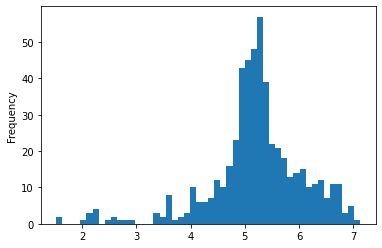

In [98]:
proj['Greenhouse Gases (CO2e)'].replace(0, np.nan).transform(np.log10).plot.hist(bins=50)

#### Date Modified

In [42]:
# to_datetime works on all values present
timestamps = pd.to_datetime(proj['modified_on'])
timestamps.dtypes, timestamps.isna().sum()

(dtype('<M8[ns]'), 0)

#### Jobs
Check array delimiter, naming, and order.

* Array delimiter: can be `,` or `;` or none
* naming: `temporary`, `permanent`, `full-time`, `construction`, `operating` and none given
* order: not consistent. Needs a parser.

In [95]:
# only 74/672 (11%) have jobs numbers
proj['Number of Jobs Promised'].dropna().shape

(74,)

In [66]:
jobs = proj['Number of Jobs Promised'].dropna()

**What special characters are present?**

In [78]:
from functools import reduce
reduce(set.union, [set(item) for item in jobs.str.replace('\d+|\w+|\s+', '', regex=True).to_list()])

{'(', ')', ',', '-', ';', '>'}

In [80]:
# not a delimiter
jobs[jobs.str.contains('>')]

550    1,000-1,500 construction jobs, >100 permanent jobs
Name: Number of Jobs Promised, dtype: object

In [81]:
# not an array delimiter. It is a range delimiter
jobs[jobs.str.contains('-')]

39     200 construction jobs; 40 full-time jobs (for the entire BWTX SMP Project, including pipeline construction)
135    1500-2000 temporary; 200 full-time                                                                         
248    1500-2000 temporary jobs                                                                                   
283    400 full-time jobs; 6,000 construction jobs                                                                
294    1400-3000 temporary; 250 permanent                                                                         
297    35-50                                                                                                      
341    40-260 temporary; 28 permanent                                                                             
443    106 full-time jobs, 2800-3025 construction jobs                                                            
527    10-20                                                                    

In [83]:
# not a delimiter
jobs[jobs.str.contains('\(|\)')]

39    200 construction jobs; 40 full-time jobs (for the entire BWTX SMP Project, including pipeline construction)
Name: Number of Jobs Promised, dtype: object

**What job types are present?**

In [93]:
jobs.str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       35
temporary       33
construction    14
jobs            11
full            4 
time            4 
operating       2 
including       1 
peak            1 
during          1 
pipeline        1 
BWTX            1 
Project         1 
SMP             1 
entire          1 
the             1 
for             1 
Unknown         1 
Name: 0, dtype: int64

In [94]:
# repeat but without that long parenthetical
jobs.str.replace('\(.+\)', '', regex=True).str.extractall('([a-zA-Z]+)')[0].value_counts()

permanent       35
temporary       33
construction    13
jobs            11
full            4 
time            4 
operating       2 
during          1 
peak            1 
Unknown         1 
Name: 0, dtype: int64

I think `permanent`, `full-time` and `operating` are equivalent. And `temporary` == `construction`. And `Unkown` is Null.

### Range Validation
Check IDs, Emissions, Cost, Jobs, expected completion year
#### Emissions
Kind of hard to interpret, but no outrageous smoking guns

In [99]:
emission_cols = [
    'Greenhouse Gases (CO2e)',
    'Particulate Matter (PM2.5)',
    'Nitrogen Oxides (NOx)',
    'Volatile Organic Compounds (VOC)',
    'Sulfur Dioxide (SO2)',
    'Carbon Monoxide (CO)',
    'Hazardous Air Pollutants (HAPs)',
]

In [111]:
# sulfur is missing due to type error
proj[emission_cols].describe()

,Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs)
count,5.450000e+02,609.000000,606.000000,613.000000,606.000000,352.000000
mean,6.882492e+05,33.898096,137.098859,245.385331,269.308492,17.123238
std,1.501951e+06,94.378938,443.168752,1673.120086,834.408524,87.675596
min,-1.303318e+06,-211.020000,-2191.800000,-77.330000,-592.500000,-59.780000
25%,7.244400e+04,3.140000,22.820000,14.560000,30.995000,1.255000
50%,1.655950e+05,8.110000,49.455000,35.500000,78.575000,4.345000
75%,4.500000e+05,21.130000,111.030000,95.940000,196.427500,12.007500
max,1.362809e+07,1303.300000,4335.000000,24636.800000,11927.400000,1230.000000


In [116]:
# a single value causes the issue
proj.loc[proj['Sulfur Dioxide (SO2)'].str.contains(',').fillna(False), ['id', 'name', 'Sulfur Dioxide (SO2)']]

,id,name,Sulfur Dioxide (SO2)
260,2989,Mt. Airy Terminal - Storage Capacity Expansion Project,"0.02, 0.02"


In [118]:
sulfur = pd.to_numeric(proj['Sulfur Dioxide (SO2)'].str.split(',').str[0], errors='raise')

In [119]:
sulfur.describe()

count    603.000000 
mean     31.058544  
std      146.053798 
min     -1132.996900
25%      0.480000   
50%      3.020000   
75%      18.365000  
max      2094.200000
Name: Sulfur Dioxide (SO2), dtype: float64

In [122]:
emission_cols.remove('Sulfur Dioxide (SO2)')

In [127]:
extremely_large_idx = [proj.loc[:, col].nlargest(5).index for col in emission_cols] + [sulfur.nlargest(5).index]

In [128]:
extremely_large = pd.Index([])
for index in extremely_large_idx:
    extremely_large = extremely_large.union(index)
extremely_large

Index([ 37,  39,  43,  92,  98, 100, 113, 137, 148, 149, 151, 152, 216, 222,
       276, 294, 306, 332, 389, 408, 426, 567, 620],
      dtype='object')

In [130]:
proj.loc[extremely_large, ['id', 'name', 'Project Description', 'Sulfur Dioxide (SO2)'] + emission_cols].sort_values('Greenhouse Gases (CO2e)')

,id,name,Project Description,Sulfur Dioxide (SO2),Greenhouse Gases (CO2e),Particulate Matter (PM2.5),Nitrogen Oxides (NOx),Volatile Organic Compounds (VOC),Carbon Monoxide (CO),Hazardous Air Pollutants (HAPs)
389,3119,Texas GulfLink Deepwater Port - Initial Construction,"The Texas GulfLink Terminal Project would consist of a Deepwater Oil Port near Freeport, Texas, capable of loading deep draft Very Large Crude Carrier (VLCC) vessels. The Deepwater Port will deliver crude oil via an onshore crude pipeline to above-ground crude oil storage tanks. Upon nomination from the crude oil shipper, the oil will be transported to one of two floating Single Point Mooring (SPM) buoys in the Gulf of Mexico, which would will allow for VLCC vessels to moor and receive up to 2 million barrels of crude oil each to be exported internationally.",20.16,8862.00,3.23,59.82,10025.14,56.59,NaN
98,2822,Coyote Springs Compressor Station.10174-01,"Construction of a new compressor station along Gas Transmission Northwest's existing pipeline, which runs from the Canadian border through the states of Idaho, Washington and Oregon to California. This permit will allow the installation of a Solar Saturn 20 turbine, a Caterpillar emergency engine generator set, a new fuel gas heater and two space heaters.",0.06,13402.00,0.56,30.43,2.46,38.24,182.95
37,2760,Blue Marlin Offshore Port - Initial Construction,"Construction of a new offshore deepwater export terminal, including the conversion of existing offshore platforms from gas transmission facilities to natural gas and crude oil facilities. The DWP would provide crude oil transportation and loading services utilizing very large crude carriers (VLCCs) (and other crude oil carriers). Oil for export will be transported out of the existing Nederland Terminal in Jefferson County.",1.64,16503.00,1.07,26.02,21881.00,57.88,1230.00
39,2762,Bluewater SPM Deepwater Port - Initial Construction,"Construction of a new deepwater port in the federal waters of the Gulf of Mexico, which would consist of two single point mooring buoys and would allow for export of domestically produced crude oil. The marine loading operations associated with the Bluewater SPM Deepwater Port would be able to handle 384 million barrels of crude oil every year.",NaN,185453.00,NaN,NaN,18936.25,NaN,833.18
426,3157,Wood River CORE Expansion and Hartford Terminal Expansion Projects.10283-01,"Modifications to increase processing capacity of heavier crude at the Wood River Refinery, including installation of two fractionation columns, three storage tanks, a cooling water tower, and one boiler.",2094.2,209350.00,161.30,920.40,327.30,882.40,NaN
151,2877,Geismar Methanol Plant 3 and G1/G2 Debottlenecking Projects,"Construction of a third methanol plant (Geismar III), which would be capable of producing 5,156 metric tons of methanol every day, as well as two debottlenecking projects at existing Geismar Methanol Units I and II. The G2 Unit debottlenecking project would increase methanol production at Geismar II by 14 percent, to 3,500 metric tons per day. If all three projects are completed, the Methanex Complex would be able to produce 12,156 metric tons of methanol every day.",1.6,457375.00,19.91,32.94,21.30,154.26,633.89
43,2766,"Borger Refinery, Crude Flexibility and Modernization Project","Installation of a new Continuous Catalytic Reformer (CCR) Unit and a new Naphtha Splitter Unit; installation of new and more efficient crude charge heaters to replace the existing crude charge heaters, and modifications in other selected refinery process units.",647.89,470082.58,890.69,368.35,644.55,2722.41,NaN
276,3005,Equistar Corpus Christi - Olefins Plant Expansion,An expansion project to increase annual ethylene production capacity by 810 million pounds.,1263.76,2062725.00,92.30,2264.06,452.81,1638.85,NaN
152,2878,Geismar Methanol Plants 1 and 2,"Construction of a new methanol plant consisting of two production units, Geismar I and Geismar II, which would each be ca

In [131]:
import matplotlib.pyplot as plt

<AxesSubplot:>

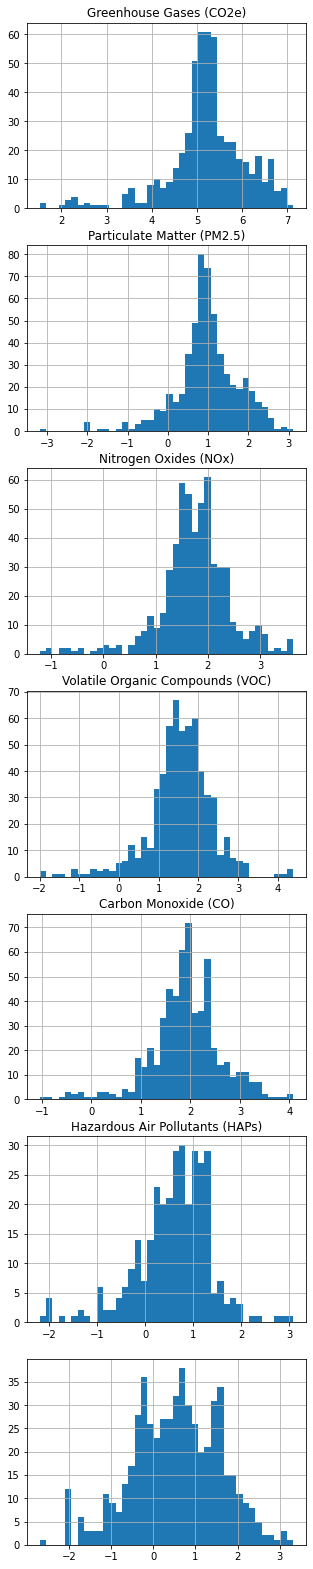

In [136]:
# NOTE: this only includes positive values (most but not all of them)
n = len(emission_cols)+1
fig, axes = plt.subplots(nrows=n, figsize=(5, n*4))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].replace(0,np.nan).transform(np.log10).hist(bins=40, ax=axes[i])
    axes[i].set_title(col)
sulfur.replace(0,np.nan).transform(np.log10).hist(bins=40, ax=axes[n-1])

<AxesSubplot:>

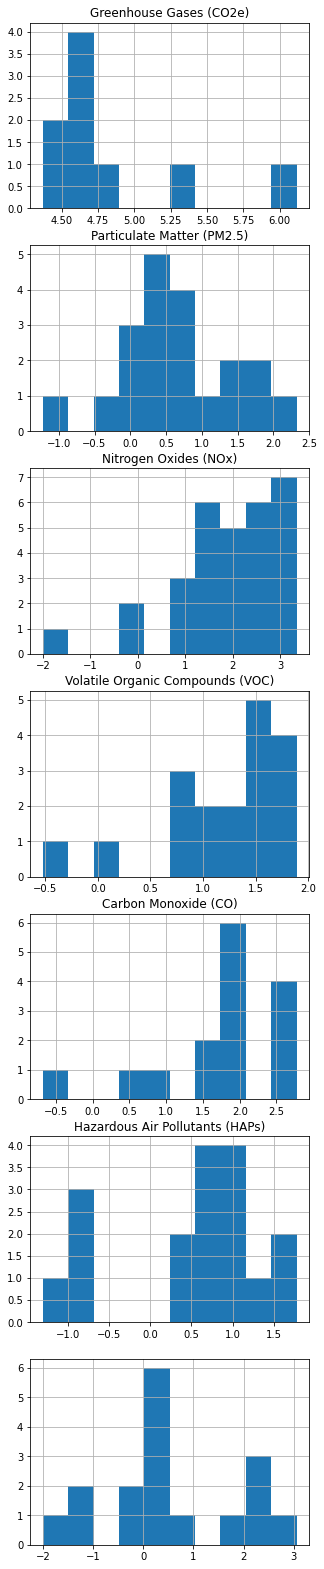

In [137]:
# Negative values only
n = len(emission_cols)+1
fig, axes = plt.subplots(nrows=n, figsize=(5, n*4))
for i, col in enumerate(emission_cols):
    proj.loc[:, col].mul(-1).replace(0,np.nan).transform(np.log10).hist(bins=10, ax=axes[i])
    axes[i].set_title(col)
sulfur.mul(-1).replace(0,np.nan).transform(np.log10).hist(bins=10, ax=axes[n-1])

#### IDs
There are lots of ID columns, but I only care about Facility IDs and Air Construction IDs

In [101]:
# defined way up near the top
id_cols

['Facility (ID)', 'Air Construction (ID)', 'Air Operating (ID)', 'NGA (ID)']

In [104]:
fac_ids = proj['Facility (ID)'].str.split(',', expand=True)
for col in fac_ids.columns:
    fac_ids.loc[:, col] = pd.to_numeric(fac_ids.loc[:, col], errors='coerce')

fac_ids.head()

,0,1,2
0,739,NaN,NaN
1,740,NaN,NaN
2,741,NaN,NaN
3,742,NaN,NaN
4,758,NaN,NaN


In [105]:
# they all look in the same range
fac_ids.describe()

,0,1,2
count,672.000000,5.000000,1.0
mean,1799.324405,3735.400000,4106.0
std,1437.372711,212.252915,NaN
min,739.000000,3598.000000,4106.0
25%,874.000000,3605.000000,4106.0
50%,1014.500000,3683.000000,4106.0
75%,3750.500000,3683.000000,4106.0
max,4866.000000,4108.000000,4106.0


In [107]:
air_const_ids = proj['Air Construction (ID)'].str.split(',', expand=True)
for col in air_const_ids.columns:
    air_const_ids.loc[:, col] = pd.to_numeric(air_const_ids.loc[:, col], errors='coerce')

air_const_ids.head()

,0,1,2,3,4,5,6
0,1573.0,1574.0,4137.0,4826.0,4878.0,NaN,NaN
1,2079.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2361.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2181.0,2182.0,4266.0,NaN,NaN,NaN,NaN
4,1578.0,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
# they all look in the same range
air_const_ids.describe()

,0,1,2,3,4,5,6
count,554.000000,170.000000,63.000000,25.000000,11.000000,5.000000,2.000000
mean,2565.200361,2754.405882,2778.904762,2446.720000,2528.090909,2266.800000,1653.000000
std,1012.288987,1138.962164,1133.062731,1067.237498,1233.418701,1060.422416,31.112698
min,1573.000000,1574.000000,1620.000000,1621.000000,1622.000000,1623.000000,1631.000000
25%,1882.250000,1891.500000,1805.000000,1672.000000,1655.000000,1630.000000,1642.000000
50%,2166.500000,2174.000000,2270.000000,2150.000000,1898.000000,1674.000000,1653.000000
75%,2432.750000,4076.250000,4092.000000,2430.000000,3182.000000,2317.000000,1664.000000
max,4881.000000,4877.000000,4862.000000,4826.000000,4878.000000,4090.000000,1675.000000


#### Project Cost
Check uniformity at the same time: should be in millions of dollars. Check vs thousands or single dollars.

<AxesSubplot:>

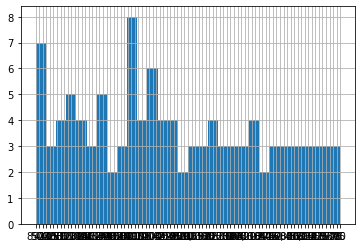

In [43]:
# wrong dtype
proj['Project Cost (million $)'].hist(bins=30)

By manual inspection (there are not that many values present), I see that there are a handful of values of the form "XX, XX". The first number is repeated in an array. So I want to use the same method that fixed the identical issue in the `State` column. But first I need to check that there are no commas present as thousands separators or for other reasons. Check that a split on commas produces two identical values:

In [46]:
proj['Project Cost (million $)'].str.split(',', expand=True).dropna()

,0,1
297,350,350
444,10,10
573,80,80
588,30,30


<AxesSubplot:>

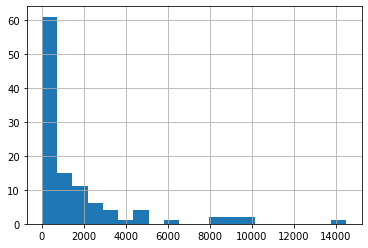

In [51]:
# definitely no single dollar amounts.
# As for thousands, check that the 8-14 billion dollar projects are plausible
cost = pd.to_numeric(proj['Project Cost (million $)'].str.split(',').str[0], errors='raise')
cost.hist(bins=20)

<AxesSubplot:>

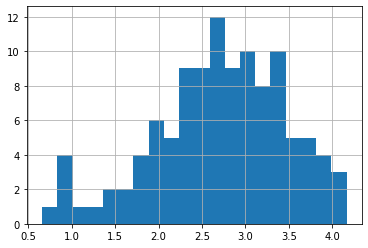

In [52]:
# log transform
cost.transform(np.log10).hist(bins=20)

In [60]:
# Yes, costs are in millions. If they were in thousands, it would mean these megafacilities were being built with 6-14.5 million dollars. I'd buy one at that price!
pd.set_option('display.max_colwidth', 0)
proj.loc[cost.nlargest(8).index, ['name', 'Project Cost (million $)', 'Project Description']]

,name,Project Cost (million $),Project Description
113,Driftwood LNG - Initial Construction,14500,Construction of a new LNG terminal with five liquefaction trains. The terminal will have the capacity to process 27.6 million metric tons of LNG per year for export.
54,Cameron LNG Phase I,10000,"Construction of a new liquefied natural gas export terminal next to the existing Cameron LNG Import Terminal. Phase I of the project would involve the construction of three liquefaction trains (Trains 1, 2, and 3), each capable of processing up to 5 million metric tons of LNG per year."
283,"GCGV Complex - Ethylene Plant, MEG Plant, LDPE Plant",10000,"Construction of a new organic chemicals manufacturing complex, which includes: an ethylene plant, a monoethylene glycol plant, two linear low density polyethylene plants, and supporting logistical and utility infrastructure."
137,Formosa Sunshine Project,9400,"Construction of a new chemical complex that would be capable of producing 960 thousand tons per year (KTA) of high density polyethylene, 1,040 KTA of low density polyethylene, 660 KTA of polypropylene, and 2,180 KTA of ethylene glycol."
303,Port Arthur LNG Base Project,9000,"The Port Arthur LNG Terminal would be constructed in two phases. The base project would consist of two liquefaction units, Trains 1 and 2, which would be capable of processing up to 13.5 million tons of LNG per year."
294,Plaquemines LNG Terminal - Initial Construction,8200,"Construction of a new liquefied natural gas export terminal, capable of processing up to 24 million tons of LNG per year. The Plaquemines LNG Project would be constructed in two phases, nine liquefaction blocks at a time, and would include six pretreatment facilities, three LNG loading berths, and two 710-megawatt electric power plants."
65,Chemical Orange Polyethylene Plant Expansion,8000,"Construction of a new ethylene cracking unit and two polyethylene units, capable of producing 2 million tons of ethylene and 2 million tons of high-density polyethylene annually."
607,Nacero Marcellus Facility - Initial Construction,6000,"Construction of the Nacero Marcellus gas to liquids facility, which would convert natural gas to syngas, hydrogen, and methanol to manufacture gasoline."


#### Jobs
Skipping for now becuase I need to make a parser first.

### Uniqueness Validation
Check the `id` field

In [109]:
proj['id'].duplicated().sum()

0

### Set Membership Validation
* classification
* industry sector
* project type
* operating status

#### Classification
Doesn't look like any erroneous categories to me.

In [138]:
proj['Classification'].value_counts()

Expansion     342
New           315
Conversion    7  
Restart       7  
Name: Classification, dtype: int64

#### Industry Sector
A single one:many array value. Simplify by picking one

In [139]:
proj['Industry Sector'].value_counts()

Natural Gas                           301
Petrochemicals and Plastics           187
Oil                                   88 
Liquefied Natural Gas                 39 
Synthetic Fertilizers                 32 
Other                                 24 
Petrochemicals and Plastics, Other    1  
Name: Industry Sector, dtype: int64

#### Project Type
This column has a fair number of multivalued array entries. But the categories themselves look consistent -- no mis-spellings, etc.

In [140]:
proj['Project Type'].value_counts()

Compressor Station                                                        240
Gas Processing Plant                                                      52 
Refinery                                                                  52 
Liquefied Natural Gas Terminal or Liquefaction Plant                      36 
Natural Gas Liquids Fractionator                                          32 
Ethylene Cracker                                                          26 
Crude Oil Terminal                                                        26 
Ammonia/Urea Plants                                                       25 
Plastic Resin Manufacturing                                               24 
Methanol Plant                                                            21 
Other Chemicals                                                           17 
Renewable Diesel or Gasoline Refinery                                     14 
Propylene Dehydrogenation (PDH) Plant                           

In [153]:
# split and combine value counts
proj['Project Type'].str.split(',', expand=True).stack().str.strip().value_counts()

Compressor Station                                      240
Gas Processing Plant                                    69 
Refinery                                                52 
Natural Gas Liquids Fractionator                        52 
Liquefied Natural Gas Terminal or Liquefaction Plant    36 
Ethylene Cracker                                        31 
Plastic Resin Manufacturing                             29 
Ammonia/Urea Plants                                     29 
Crude Oil Terminal                                      27 
Methanol Plant                                          22 
Other Chemicals                                         20 
Renewable Diesel or Gasoline Refinery                   14 
Propylene Dehydrogenation (PDH) Plant                   12 
Hydrogen Plant                                          12 
Natural Gas Liquids Storage Facility                    11 
Gas-Fired Power Plant                                   8  
Associated Electricity Generation       

#### Operating Status
Just need to replace "Unknown" with Null

In [155]:
proj['Operating Status'].value_counts()

Operating              364
Pre-construction       170
Announced              40 
Under construction     35 
Canceled               30 
Partially operating    16 
On hold                15 
Unknown                1  
Commissioning          1  
Name: Operating Status, dtype: int64

### Type Validation
Already did this while doing range validation, but `Sulfur Dioxide (SO2)`and `Project Cost` require parsing duplicative csv array values in what should be a numeric column. Also, `Number of Jobs Promised` needs parsing into two columns: permanent and temporary jobs.

#### Completion Year
I started converting this to numeric, but would have to model multi-valued items. I think the benefit (sorting, quantitative analysis) is small relative to 1) the cost it will take to communicate the modeling and 2) actually doing the modelling. I think we have other fields we would filter on first.

<AxesSubplot:>

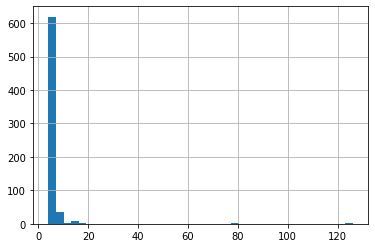

In [159]:
proj['Actual or Expected Completion Year'].str.len().hist(bins=40)

In [160]:
proj['Actual or Expected Completion Year'].str.len().nlargest(8)

567    126.0
332    79.0 
629    19.0 
658    16.0 
203    14.0 
230    14.0 
266    14.0 
274    14.0 
Name: Actual or Expected Completion Year, dtype: float64

In [161]:
proj.loc[proj['Actual or Expected Completion Year'].str.len().nlargest(8).index, 'Actual or Expected Completion Year']

567    Train 5 began operating in 2019. Commissioning of Train 6 began in November 2021, with full completion expected in early 2022.
332    Trains 1 and 2 began operating in 2016. Trains 3 and 4 began operating in 2017.                                               
629    2015/2018/2020/2022                                                                                                           
658    2024, 2024, 2024                                                                                                              
203    2018/2020/2021                                                                                                                
230    2013/2015/2020                                                                                                                
266    2015/2017/2020                                                                                                                
274    2014/2016/2018                                         

### Cross-Field Validation
None really needed. I could check that the date columns are in a logical order (modified > created, for example) but I'm not planning to really use those columns. So I skipped it.